<a href="https://colab.research.google.com/github/Abby-Wale/CNN_For_Dementia/blob/main/deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# deep-learning-project

Use the "Run" button to execute the code.

In [ ]:
!pip install opendatasets --upgrade --quiet
!pip install jovian --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import opendatasets as od
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
import math
import shutil
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import jovian

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset/download?datasetVersionNumber=1'
od.download(dataset_url)

100%|██████████| 28.0M/28.0M [00:00<00:00, 77.2MB/s]


In [ ]:
dementia_data = '/content/alzheimer-mri-dataset/Dataset'

In [ ]:
os.listdir(dementia_data)

['Non_Demented', 'Very_Mild_Demented', 'Moderate_Demented', 'Mild_Demented']

In [ ]:
for cls in os.listdir(dementia_data):
    print(cls, ':', len(os.listdir(dementia_data + '/' + cls)))

Non_Demented : 3200
Very_Mild_Demented : 2240
Moderate_Demented : 64
Mild_Demented : 896


In [ ]:
dataset = ImageFolder(dementia_data)
len(dataset)

6400

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=128x128 at 0x7F1B39CCBB50>, 0)

In [ ]:
dataset.classes

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

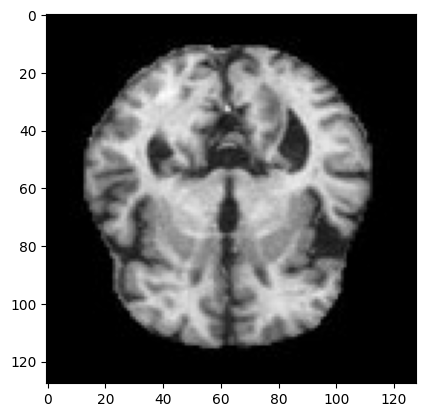

In [ ]:
img, label = dataset[120]
plt.imshow(img)

In [ ]:
dataset = ImageFolder(dementia_data, tt.Compose([tt.Resize(64),
                                                 tt.RandomCrop(64),
                                                 tt.ToTensor()]))

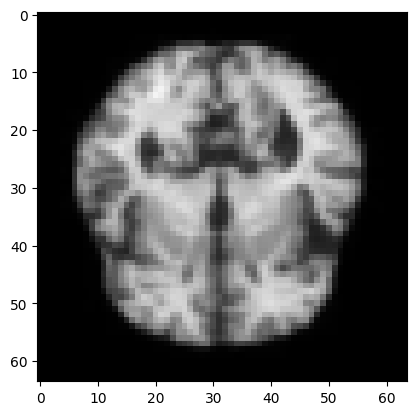

In [ ]:
img, label = dataset[120]
plt.imshow(img.permute((1, 2, 0)))

In [ ]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(5760, 640)

In [ ]:
train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(5760, 640)

In [ ]:
batch_size = 64

train_dl = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=4, 
                      pin_memory=True)

valid_dl = DataLoader(valid_ds, 
                    batch_size, 
                    num_workers=4, 
                    pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


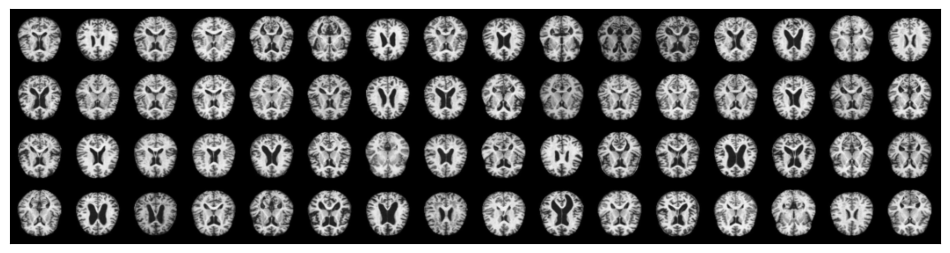

In [ ]:

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_dl)

##GPU UTILITIES



In [ ]:

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()

In [ ]:
device

device(type='cuda')

In [ ]:
img, label = dataset[0]

In [ ]:
img.device

device(type='cpu')

In [ ]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        "calculate loss for a batch of training data"
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        "calculate loss & accuracy for a batch of validation data"
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

##MODEL

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
model.conv1[0].weight.device

device(type='cuda', index=0)

In [ ]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

images.shape torch.Size([64, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([64, 4])


##TRAINING

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.3629486560821533, 'val_acc': 0.38593751192092896}]

In [ ]:
history += fit(4, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.1658, val_loss: 0.7599, val_acc: 0.6484
Epoch [1], train_loss: 0.7625, val_loss: 0.6153, val_acc: 0.7328
Epoch [2], train_loss: 0.3803, val_loss: 1.4234, val_acc: 0.5437
Epoch [3], train_loss: 0.1697, val_loss: 1.2780, val_acc: 0.5734


In [ ]:
history += fit(4, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.1411, val_loss: 0.7232, val_acc: 0.7484
Epoch [1], train_loss: 0.0747, val_loss: 0.4313, val_acc: 0.8641
Epoch [2], train_loss: 0.0294, val_loss: 0.5044, val_acc: 0.8109
Epoch [3], train_loss: 0.0147, val_loss: 3.7754, val_acc: 0.4250


In [ ]:
history += fit(4, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.0466, val_loss: 0.1809, val_acc: 0.9281
Epoch [1], train_loss: 0.0249, val_loss: 2.1002, val_acc: 0.8172
Epoch [2], train_loss: 0.0252, val_loss: 0.0632, val_acc: 0.9766
Epoch [3], train_loss: 0.0639, val_loss: 0.2257, val_acc: 0.9141


In [ ]:
history += fit(4, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.0286, val_loss: 0.5938, val_acc: 0.8562
Epoch [1], train_loss: 0.0451, val_loss: 2.0125, val_acc: 0.6562
Epoch [2], train_loss: 0.0237, val_loss: 0.1277, val_acc: 0.9484
Epoch [3], train_loss: 0.0151, val_loss: 0.8578, val_acc: 0.7563


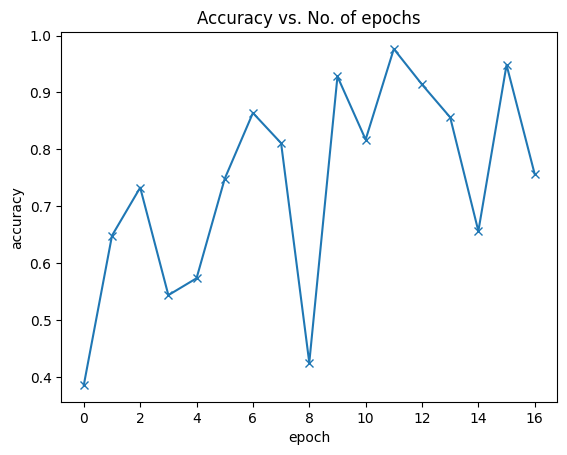

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

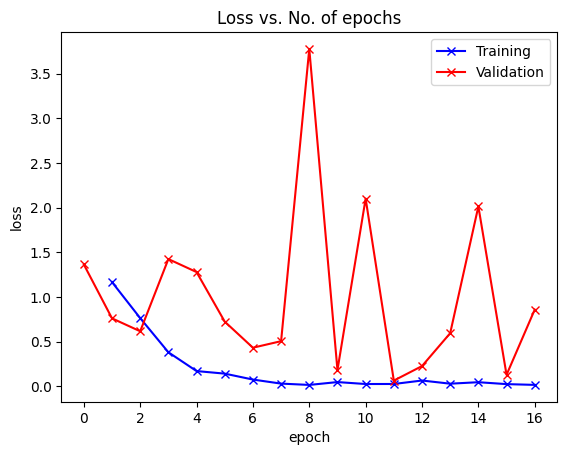

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [ ]:
history[-1]

{'val_loss': 0.8577849268913269,
 'val_acc': 0.7562500238418579,
 'train_loss': 0.015144335106015205}

In [ ]:
jovian.reset()
jovian.log_dataset(image_size=64)
jovian.log_hyperparams(batch_size=128, 
                       arch='ResNet9', 
                       epochs=[5, 5, 5, 5], 
                       lrs=[0.001, 0.001, 1e-4, 1e-4],
                       opt=['Adam', 'Adam', 'Adam', 'SGD'])
jovian.log_metrics(train_loss=history[-1]['train_loss'],
                   val_acc=history[-1]['val_acc'],
                   val_loss=history[-1]['val_loss'])

In [ ]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [ ]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Target: Non_Demented
Prediction: Non_Demented


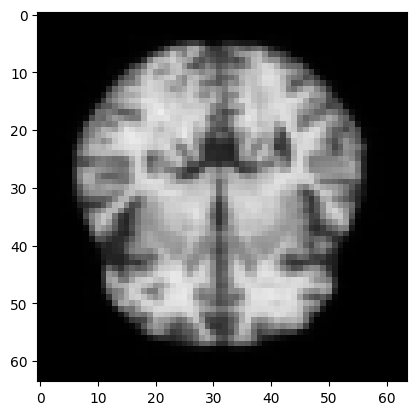

In [ ]:
show_image_prediction(*valid_ds[100])

Target: Non_Demented
Prediction: Non_Demented


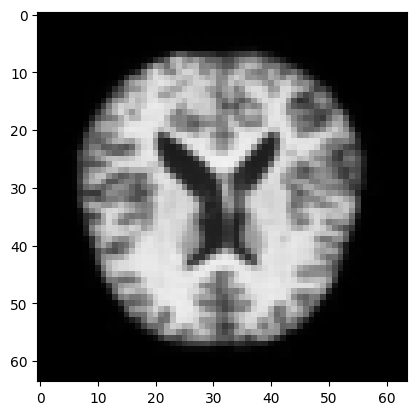

In [ ]:
show_image_prediction(*valid_ds[150])

Target: Mild_Demented
Prediction: Non_Demented


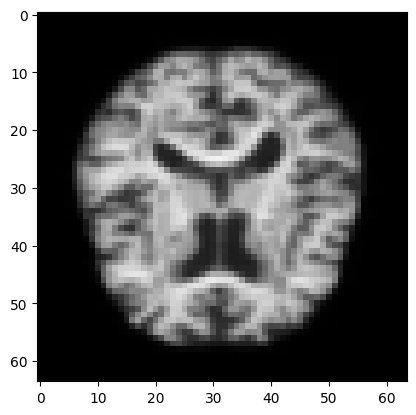

In [ ]:
show_image_prediction(*valid_ds[200])

Target: Mild_Demented
Prediction: Mild_Demented


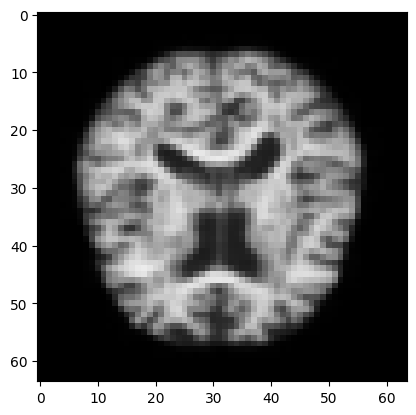

In [ ]:
show_image_prediction(*valid_ds[101])

In [ ]:
torch.save(model.state_dict(), 'dementia-resnet9.pth')